# Truncating Pauli terms during backpropagation

This guide explains how to configure the Pauli term truncation mechanism provided by the [qiskit_addon_obp.utils.truncating](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.truncating.html) module.

Operator backpropagation (OBP) can be used to reduce the depth of quantum circuits at the cost of a more complex observable. In order to get meaningful results from OBP, one usually needs to truncate terms from their observable to prevent it from growing too large. One way to allow for deeper backpropagation into the circuit, while preventing the operator from growing too large, is to truncate terms with small coefficients, rather than adding them to the operator. Truncating terms can result in fewer quantum circuits to execute, but doing so results in some error in the final expectation value calculation proportional to the magnitude of the truncated terms' coefficients.

The [backpropagate](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.backpropagate.html) method takes an optional [TruncationErrorBudget](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.truncating.TruncationErrorBudget.html) which configures the truncation of low-weight Pauli terms for each observable after the successful backpropagation of every slice.
The amount of terms that are truncated depends on various configuration parameters specified by the user.
As of now, only a single truncation strategy is available -- the [truncate_binary_search](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.truncating.truncate_binary_search.html) method.
Given an observable and some _budget_ it will perform a binary search over the Pauli terms and coefficients within that observable to find the optimal threshold,
such that the sum of the truncated coefficients is maximal but lower than the budget.

**Note**: By default, the L1 norm is used to evaluate and bound the truncation error; however, the `p_norm` setting enables the specification of the Lp-norm to be used.
For more information on how to use that setting, please refer to [its how-to guide](https://qiskit.github.io/qiskit-addon-obp/how_tos/bound_error_using_p_norm.html).

In the following examples, we will get to know various ways of building an [TruncationErrorBudget](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.truncating.TruncationErrorBudget.html) via the accompanying [setup_budget](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.truncating.setup_budget.html) function.

## Constructing an example circuit

For the purposes of this guide, we will use the following circuit slices:

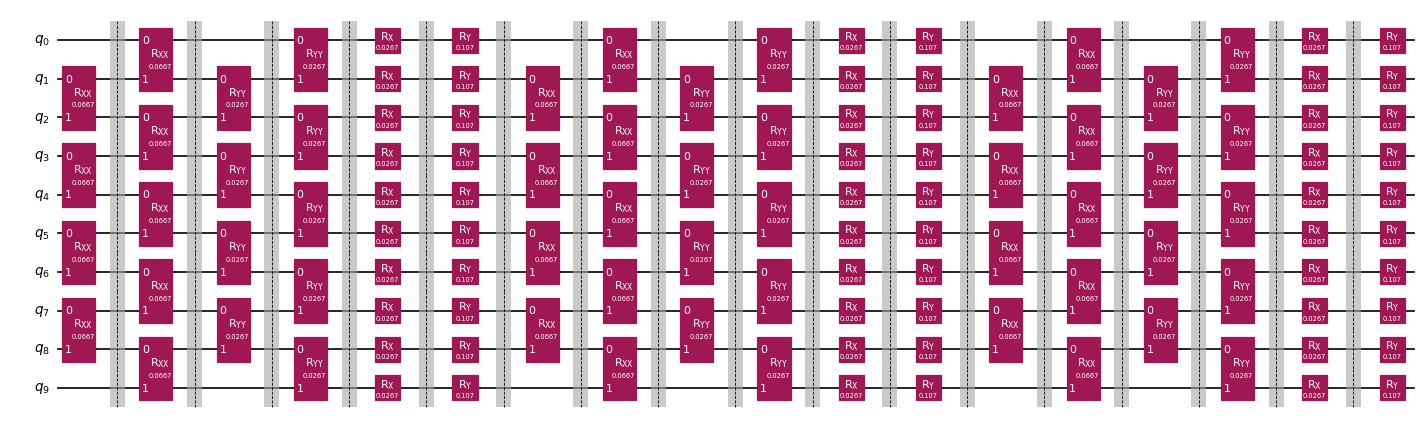

In [1]:
import rustworkx.generators
from qiskit.synthesis import LieTrotter
from qiskit_addon_utils.problem_generators import (
    PauliOrderStrategy,
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import combine_slices, slice_by_gate_types

# we generate a linear chain of 10 qubits
linear_chain = rustworkx.generators.path_graph(10)

# we use an arbitrary XY model
hamiltonian = generate_xyz_hamiltonian(
    linear_chain,
    coupling_constants=(0.05, 0.02, 0.0),
    ext_magnetic_field=(0.02, 0.08, 0.0),
    pauli_order_strategy=PauliOrderStrategy.InteractionThenColor,
)
# we evolve for some time
circuit = generate_time_evolution_circuit(hamiltonian, synthesis=LieTrotter(reps=3), time=2.0)
# slice the circuit by gate type
slices = slice_by_gate_types(circuit)

# for visualization purposes only, we recombine the slices with barriers between them and draw the resulting circuit
combine_slices(slices, include_barriers=True).draw("mpl", fold=50, scale=0.6)

We will look at a single simple observable:

In [2]:
from qiskit.quantum_info import SparsePauliOp

obs = SparsePauliOp("IIIIIZIIII")

## The simplest case: a fixed truncation budget for each slice

The available budget for truncation of Pauli terms can vary at each step of the backpropagation.
As a first step towards understanding how this works, we look at the simplest case of a fixed truncation budget as specified by the user.

The most straight-forward way to specify the truncation budget is via the `max_error_per_slice` argument.
In fact, this is what is being done in [this tutorial](https://qiskit.github.io/qiskit-addon-obp/tutorials/01_getting_started.ipynb). Setting `max_error_per_slice` to a `float` results in each slice being allotted a budget equaling that value.
In the example below, we set this value to `0.001` which guarantees us an implicit truncation error of at most `0.018`, if the entire 18 slices were to be backpropagated. 

<div class="alert alert-info">
Note that any error budget remaining after backpropagating a slice and truncating terms with small coefficients will always be added to the following slice's error budget.
</div>

In [3]:
from qiskit_addon_obp.utils.truncating import setup_budget

truncation_error_budget = setup_budget(max_error_per_slice=0.001)
print(truncation_error_budget)

TruncationErrorBudget(per_slice_budget=[0.001], max_error_total=inf, p_norm=1)


In [4]:
from qiskit_addon_obp import backpropagate
from qiskit_addon_obp.utils.simplify import OperatorBudget

op_budget = OperatorBudget(max_qwc_groups=10)
bp_obs, remaining_slices, metadata = backpropagate(
    obs, slices, operator_budget=op_budget, truncation_error_budget=truncation_error_budget
)
reduced_circuit = combine_slices(remaining_slices)
print(f"Backpropagated {len(slices) - len(remaining_slices)} circuit slices.")
print(
    f"New observable contains {len(bp_obs)} terms and {len(bp_obs.group_commuting(qubit_wise=True))} commuting groups."
)

Backpropagated 11 circuit slices.
New observable contains 29 terms and 10 commuting groups.


Let's use the [OBPMetadata](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.metadata.OBPMetadata.html) instance and the tools provided by the [visualization](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.visualization.html) module to visualize the backpropagation process.

- **The top/left plot** shows that we have enough budget to begin truncating observable terms after backpropagating the third slice. Starting from the third slice, we know that we truncate at least one term from each slice we backpropagate because we are incurring some truncation error after each slice.
- **The top/right plot** shows that the error budget ramps up to `.003` for the third slice. We see a sharp drop in remaining budget, which means terms were truncated from the observable. This is consistent with what we inferred from the top/left plot.
- **The bottom/left plot** shows that as we truncate terms from our observable, our overall accumulated error is growing monotonically. This graph also confirms that no terms were truncated until after the third slice had been backpropagated.
- **The bottom/right plot** shows that the number of commuting Pauli groups in our observable has grown to the specified limit of `10`. This plot also shows how backpropagating one more layer would cause our observable to outgrow the specified bound as you can see from the cross-over of the black and red lines.

<div class="alert alert-info">
Note that in all of these plots, the x-axis enumerates the backpropagated slices, but since OBP works on the end of the circuit, slice 1 is in fact the very last slice, slice 2 the one before that, and so on.
</div>

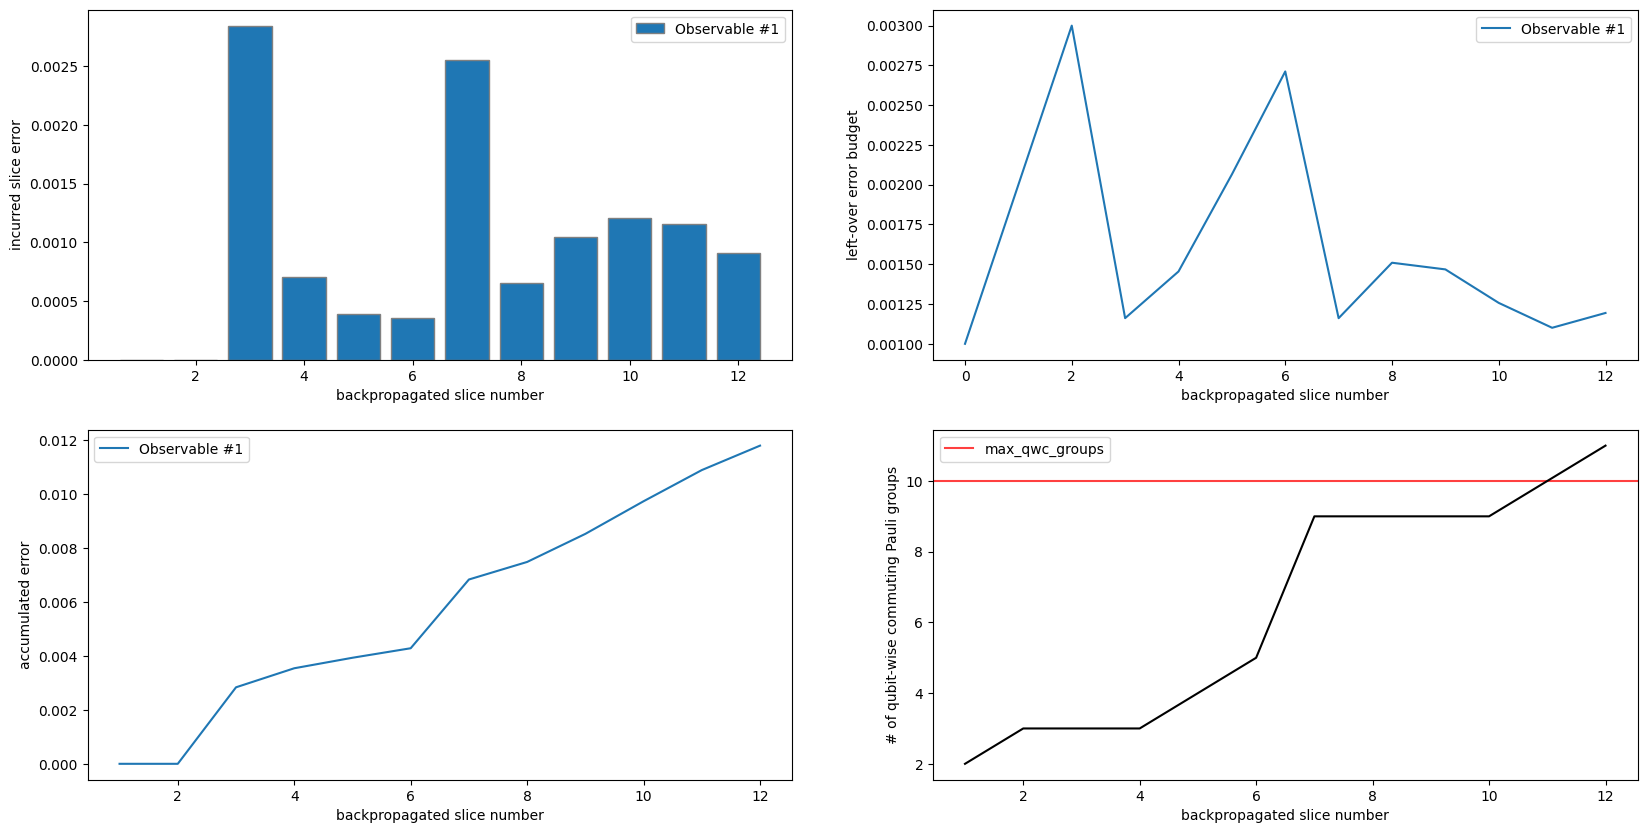

In [5]:
from matplotlib import pyplot as plt
from qiskit_addon_obp.utils.visualization import (
    plot_accumulated_error,
    plot_left_over_error_budget,
    plot_num_qwc_groups,
    plot_slice_errors,
)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
plot_slice_errors(metadata, axes[(0, 0)])
plot_left_over_error_budget(metadata, axes[(0, 1)])
plot_accumulated_error(metadata, axes[(1, 0)])
plot_num_qwc_groups(metadata, axes[(1, 1)])

## Specifying slice budget explicitly

If one has knowledge of how to assign a budget to each slice, such that the backpropagation performance is optimized, they may want to explicitly assign a budget for each slice. For demonstration purposes, let's assign the first 3 slices zero budget and use the same budget budget of `.001` per slice for the remaining slices.

In [6]:
# Zero out the first 3 slices' budgets
max_error_per_slice = [0.0] * 3 + [0.001] * (len(slices) - 3)

truncation_error_budget = setup_budget(max_error_per_slice=max_error_per_slice)
print(truncation_error_budget)

TruncationErrorBudget(per_slice_budget=[0.0, 0.0, 0.0, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001], max_error_total=inf, p_norm=1)


In [7]:
bp_obs, remaining_slices, metadata = backpropagate(
    obs, slices, operator_budget=op_budget, truncation_error_budget=truncation_error_budget
)
reduced_circuit = combine_slices(remaining_slices)
print(f"Backpropagated {len(slices) - len(remaining_slices)} circuit slices.")
print(
    f"New observable contains {len(bp_obs)} terms and {len(bp_obs.group_commuting(qubit_wise=True))} commuting groups."
)

Backpropagated 11 circuit slices.
New observable contains 32 terms and 10 commuting groups.


Removing the budget from the first 3 layers resulted in no terms being truncated until after the fourth layer, as can be confirmed in 3 of these 4 plots. What may be somewhat surprising is that although the 4th slice had no leftover budget passed to it, a term was still truncated using the allocated `.001` budget. This is obvious from the **top/left** plot but can also be observed in the **top/right** plot, as the left-over budget curve flattens between slice ID's 3 and 4. Another notable detail is that at least one term was truncated from this point on, same as above.

The key takeaway is that although we incurred less truncation error in this second example due to zeroing out some slices' budgets, we were able to backpropagate the same number of slices, and our observable contains the same number of commuting Pauli groups. We can confirm that the bound on our error is smaller in the second example by inspecting the **bottom/left** plot.

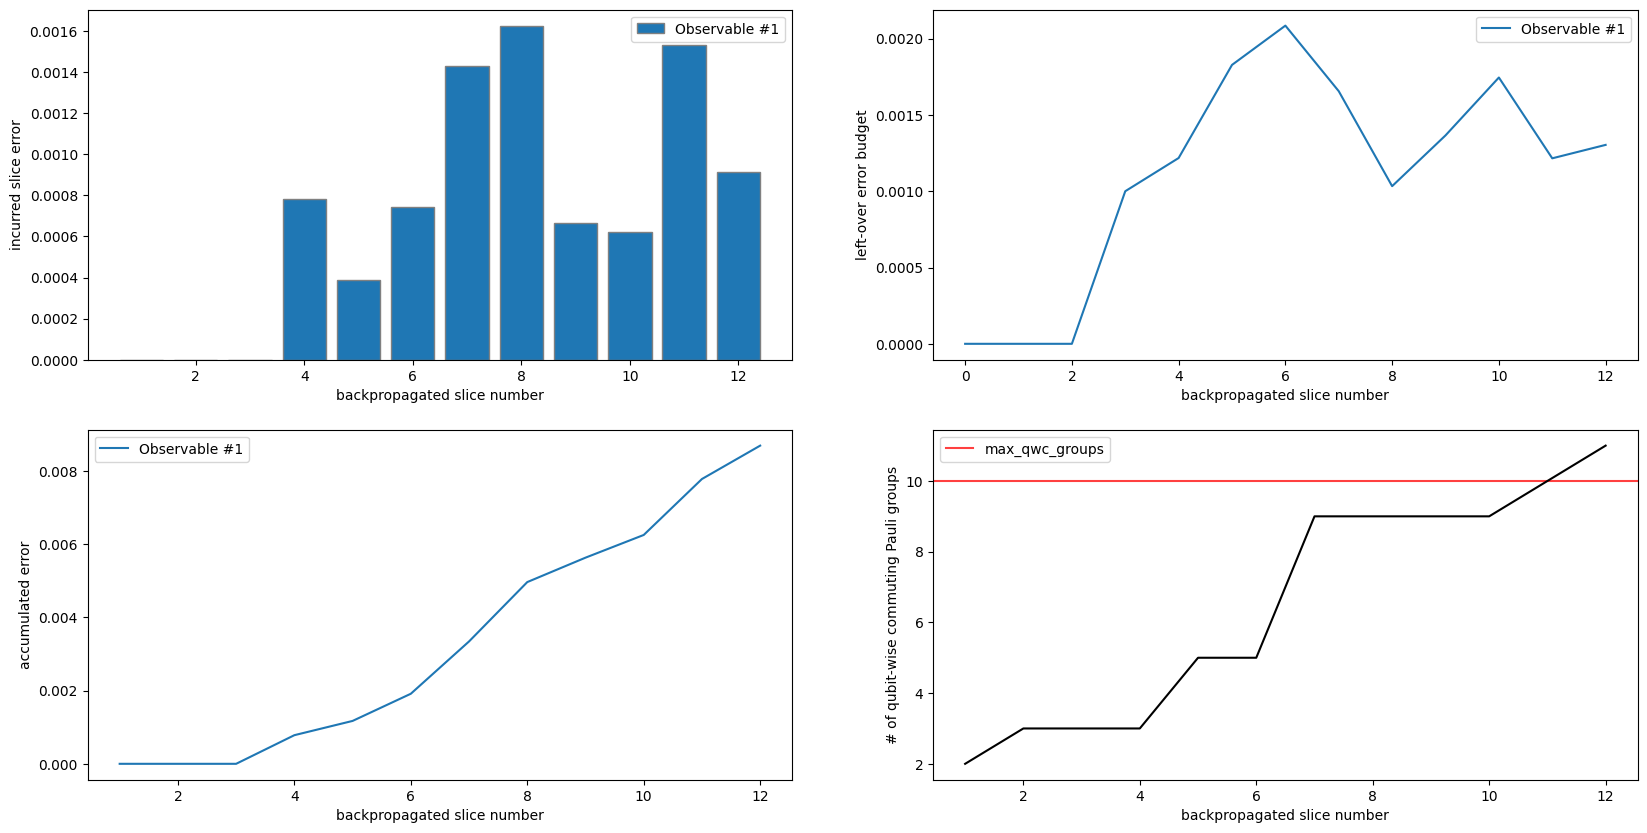

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
plot_slice_errors(metadata, axes[(0, 0)])
plot_left_over_error_budget(metadata, axes[(0, 1)])
plot_accumulated_error(metadata, axes[(1, 0)])
plot_num_qwc_groups(metadata, axes[(1, 1)])

## Specifying the budget cyclically

If one has a circuit with some repeatable pattern, such as a Trotter circuit, it may be desired to specify a budget for that repeated subset of slices and have that budget used for all of the following repetitions of those slices.

More concretely, the example circuit we are using has 6 slices which are repeated 3 times for a total of 18 slices. Here we will arbitrarily assign zero budget to the single-qubit and `RYY` layers and `.003` budget to each of the `RXX` layers. We will observe how specifying the budget as a length-6 sequence causes the budget to be applied to all 18 slices cyclically.

<div class="alert alert-info">
Once more pay attention to the fact that the slices are backpropagated in reverse order (i.e. starting at the end). Therefore, the first entry in our cyclic budget actually gets used for the last slice, the second entry for the slice before that, and so on.
</div>

In [9]:
# Specify a length-6 per-slice budget.
# This will be cycled over 3 times to be applied to the 18 slices
max_error_per_slice = [0.0] * 4 + [0.003] * 2

truncation_error_budget = setup_budget(max_error_per_slice=max_error_per_slice)
print(truncation_error_budget)

TruncationErrorBudget(per_slice_budget=[0.0, 0.0, 0.0, 0.0, 0.003, 0.003], max_error_total=inf, p_norm=1)


In [10]:
op_budget = OperatorBudget(max_qwc_groups=20)
bp_obs, remaining_slices, metadata = backpropagate(
    obs, slices, operator_budget=op_budget, truncation_error_budget=truncation_error_budget
)
reduced_circuit = combine_slices(remaining_slices)
print(f"Backpropagated {len(slices) - len(remaining_slices)} circuit slices.")
print(
    f"New observable contains {len(bp_obs)} terms and {len(bp_obs.group_commuting(qubit_wise=True))} commuting groups."
)

Backpropagated 13 circuit slices.
New observable contains 49 terms and 14 commuting groups.


As seen in the **top/left** and **bottom/left**, no truncation was performed over the first four slices since they were allocated no error budget. Slices 5 and 6 had some of their terms truncated as budget became available.

As seen in the **top/left**, a relatively large amount of error was incurred after backpropagating slice 7, even though that slice was allocated no budget. This is because only about `.002` of the `.006` total budget allocated to slices 5 and 6 was used, so the remaining was forwarded to slice 7 and mostly expended, as seen in the **top/right**.

**top/left** and **top/right** show that the small amount of leftover budget is used up between slices 8-10, and new budget becomes available in slice 11, as expected. **top/left**, **top/right**, and **bottom/left** all demonstrate the cyclical behavior of the `max_error_per_slice` argument when its length is less than the number of slices. This cyclical behavior would have continued through all the slices, but the `max_qwc_groups` stopping criteria was reached after backpropagating 13 slices, as seen in **bottom/right**.

Another interesting thing is that the number of Pauli groups actually drops after the second round of budget becomes available at slice 11. This is because there were groups with small coefficients which could not be truncated until there was more budget after backpropagating slice 11, so they accumulated in the observable for several iterations. This particular case also highlights that `max_qwc_groups` must be _exceeded_ for the algorithm to terminate.

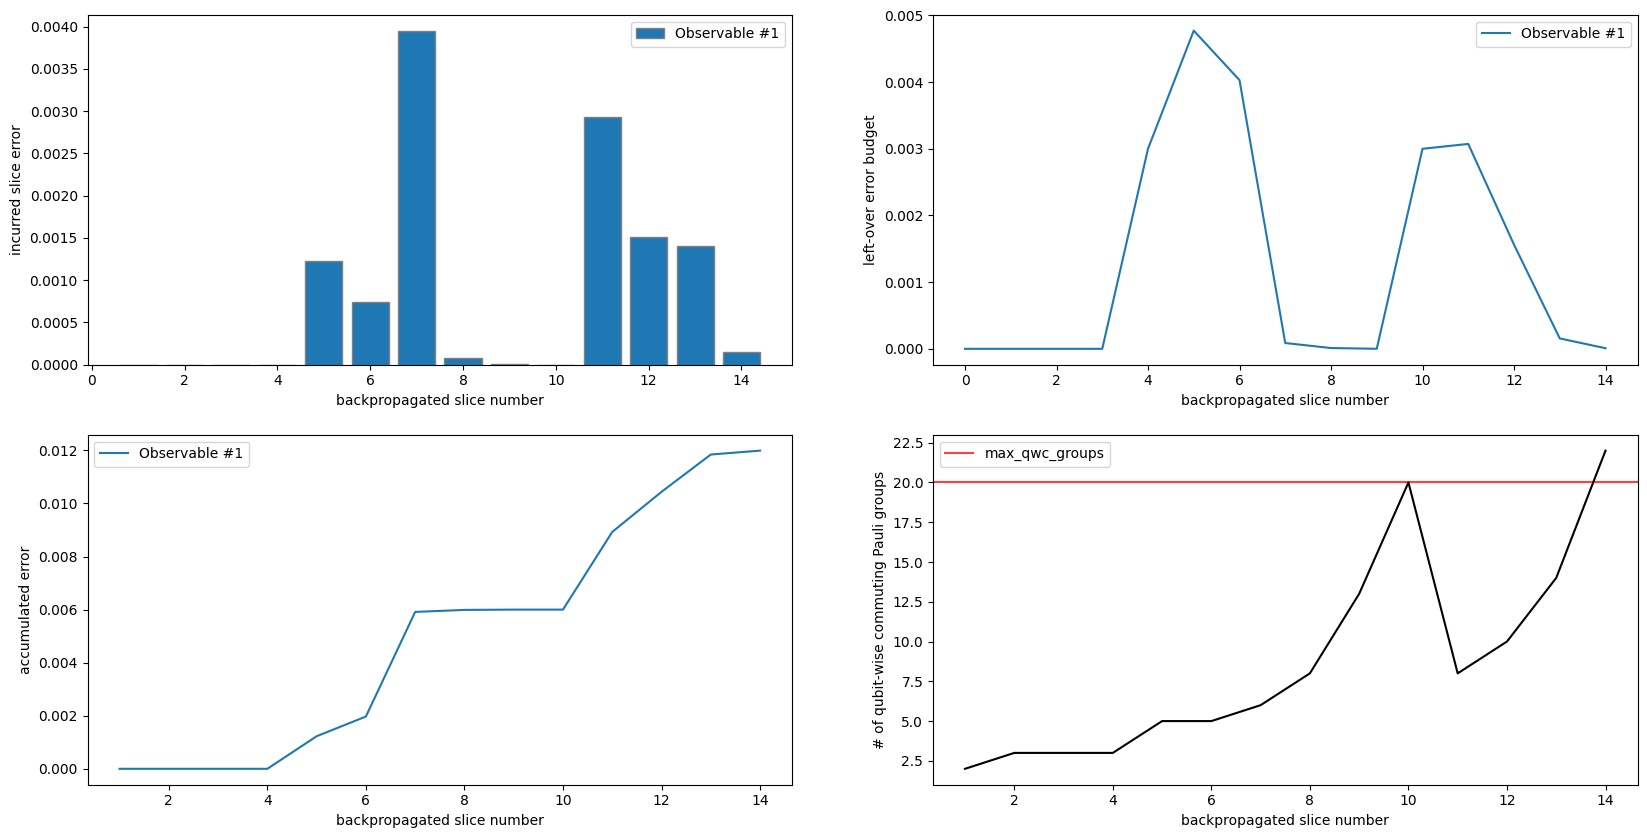

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
plot_slice_errors(metadata, axes[(0, 0)])
plot_left_over_error_budget(metadata, axes[(0, 1)])
plot_accumulated_error(metadata, axes[(1, 0)])
plot_num_qwc_groups(metadata, axes[(1, 1)])

## Capping the total error

In addition to specifying the per-slice error budget, one can specify the maximum amount of error to incur from truncation. Once that limit is hit, no more truncation will be performed; however, backpropagation will continue until the observable becomes too large and one of the stopping criteria is met.

Let's re-run the above experiment but set a cap on `max_error_total` such that the error budget is expended after backpropagating slice 7.

In [12]:
# Specify a length-6 per-slice budget.
# This will be cycled over 3 times to be applied to the 18 slices
max_error_per_slice = [0.0] * 4 + [0.003] * 2

truncation_error_budget = setup_budget(
    max_error_per_slice=max_error_per_slice, max_error_total=0.006
)
print(truncation_error_budget)

TruncationErrorBudget(per_slice_budget=[0.0, 0.0, 0.0, 0.0, 0.003, 0.003], max_error_total=0.006, p_norm=1)


In [13]:
bp_obs, remaining_slices, metadata = backpropagate(
    obs,
    slices,
    operator_budget=op_budget,
    truncation_error_budget=truncation_error_budget,
)
reduced_circuit = combine_slices(remaining_slices)
print(f"Backpropagated {len(slices) - len(remaining_slices)} circuit slices.")
print(
    f"New observable contains {len(bp_obs)} terms and {len(bp_obs.group_commuting(qubit_wise=True))} commuting groups."
)

Backpropagated 10 circuit slices.
New observable contains 67 terms and 20 commuting groups.


As expected, our truncation error caps out at `.006` (**bottom/left**). It is notable that in this run we were not able to backpropagate slice 11. This is because we did not have enough budget to truncate terms and the number of commuting Pauli groups grew past the limit of `20`, as seen in **bottom/right**.

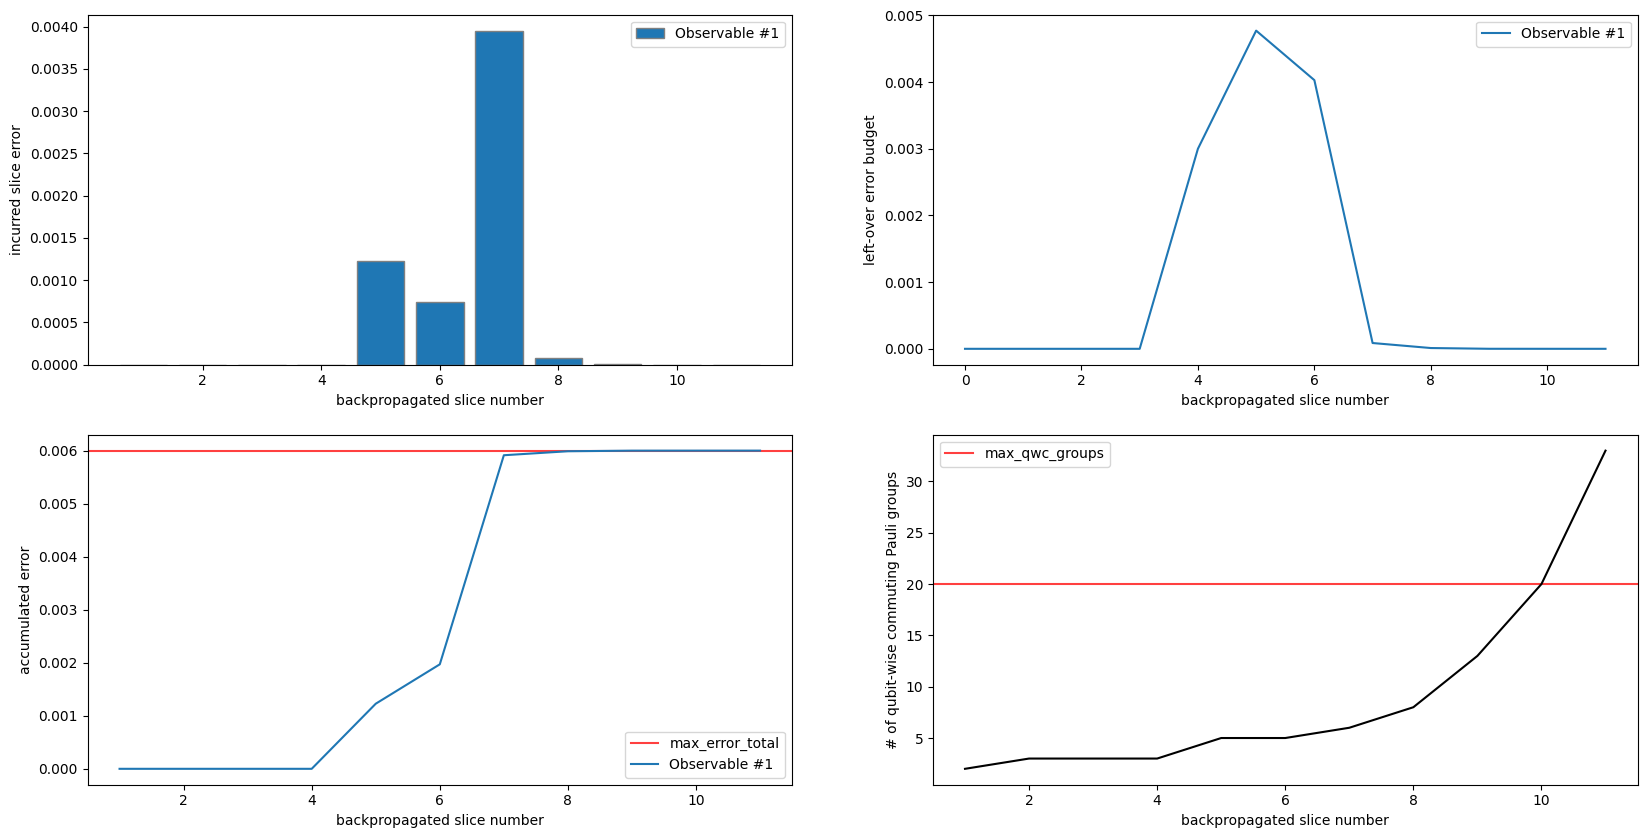

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
plot_slice_errors(metadata, axes[(0, 0)])
plot_left_over_error_budget(metadata, axes[(0, 1)])
plot_accumulated_error(metadata, axes[(1, 0)])
plot_num_qwc_groups(metadata, axes[(1, 1)])

It may be desirable to simply cap the overall budget with `max_error_total` without specifying `max_error_per_slice`.

In [15]:
truncation_error_budget = setup_budget(max_error_total=0.018)
print(truncation_error_budget)

TruncationErrorBudget(per_slice_budget=[0.018], max_error_total=0.018, p_norm=1)


The output of the cell above, might be slightly surprising because the `per_slice_budget` is set to the `max_error_total`. This indicates, that the entire available budget will be consumed **greedily**.
You can think of it this way: the entire budget is available to each slice (because we loop over the `per_slice_budget`). But any budget that has already been consumed, will be deducted from the budget that is available at that given point in the algorithm.

In [16]:
op_budget = OperatorBudget(max_qwc_groups=10)
bp_obs, remaining_slices, metadata = backpropagate(
    obs, slices, operator_budget=op_budget, truncation_error_budget=truncation_error_budget
)
reduced_circuit = combine_slices(remaining_slices)
print(f"Backpropagated {len(slices) - len(remaining_slices)} circuit slices.")
print(
    f"New observable contains {len(bp_obs)} terms and {len(bp_obs.group_commuting(qubit_wise=True))} commuting groups."
)

Backpropagated 9 circuit slices.
New observable contains 25 terms and 9 commuting groups.


**top/right** shows how the entire `.018` error budget is made available to the first slice. No truncation is performed until the third slices, so the left-over budget remains constant. The budget monotonically decreases, as the full budget is made available to each backpropagated slice until it is expended.

It is notable that this experiment yielded two fewer backpropagated slices compared to the first experiment in this notebook, which is almost identical. This demonstrates that for some problems distributing the budget evenly might be optimal. For other problems, allowing slices to greedily expend the full budget might yield better performance.

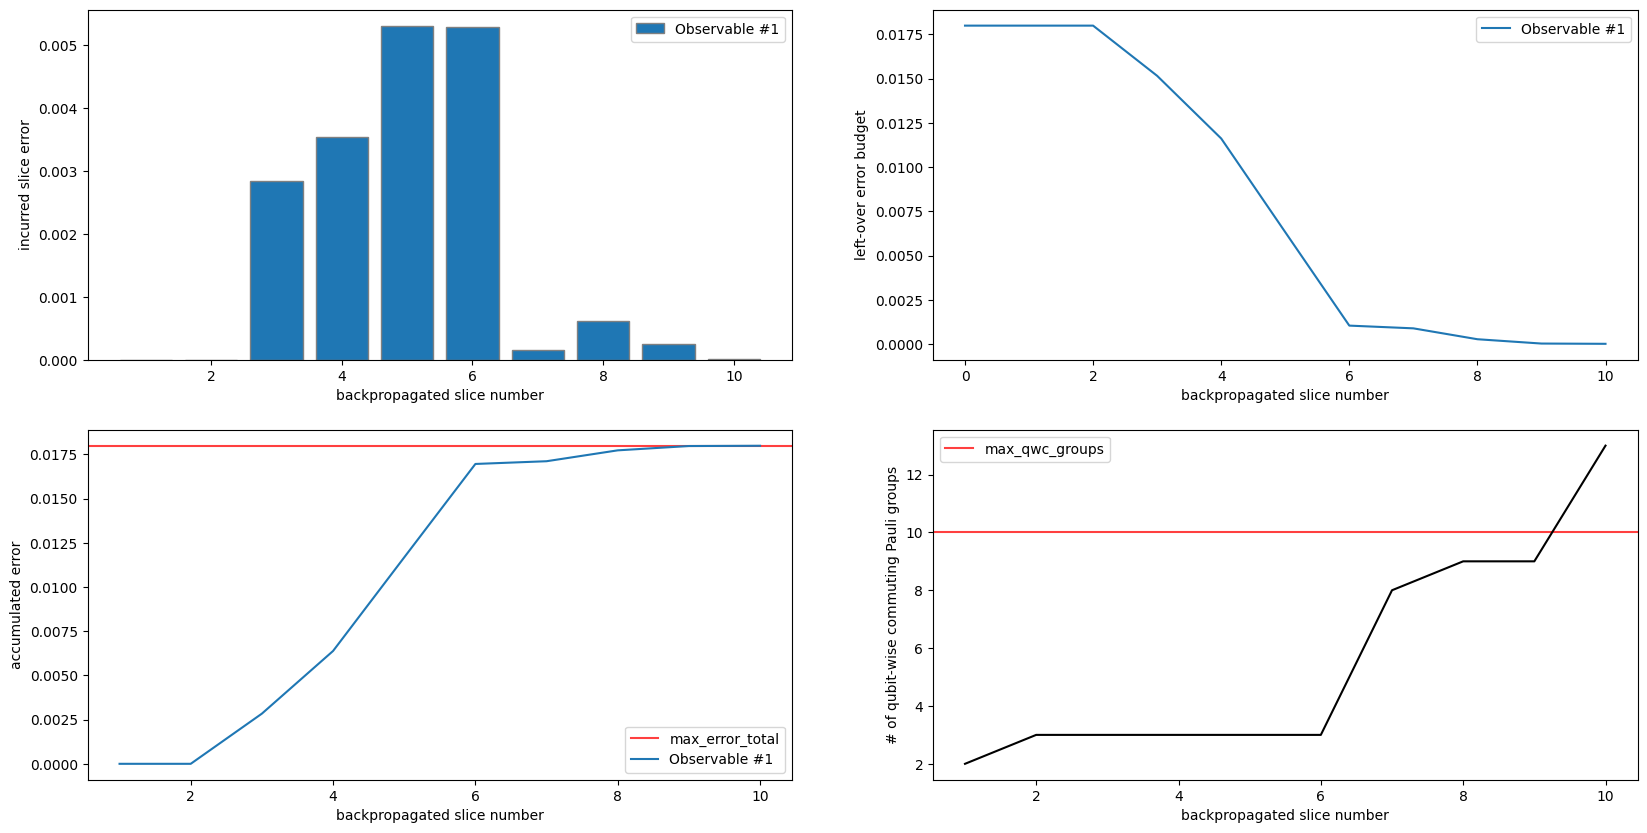

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
plot_slice_errors(metadata, axes[(0, 0)])
plot_left_over_error_budget(metadata, axes[(0, 1)])
plot_accumulated_error(metadata, axes[(1, 0)])
plot_num_qwc_groups(metadata, axes[(1, 1)])

## Capping the number of backpropagated slices and the total error together

If one doesn't want to distribute their error budget all the way through the circuit but doesn't want to greedily expend it either, one can specify a the number of slices they intend to backpropagate (`num_slices`), along with a total error budget (`max_error_total`). This will distribute the error budget uniformly (accordingly to `p_norm`) across the input slices.

Here, we will cap the number of slices we may backpropagate at `12`, and we will keep the same total error budget.

In [18]:
num_slices = 12

truncation_error_budget = setup_budget(max_error_total=0.018, num_slices=num_slices, p_norm=1)
print(truncation_error_budget)

TruncationErrorBudget(per_slice_budget=[0.0014999999999999998], max_error_total=0.018, p_norm=1)


Now we will attempt to backpropagate the `12` slices for which we allocated some budget in the previous step. We do this by just passing in the final `12` slices in our circuit. With `p_norm=1`, each of the `12` slices has an available budget of `0.018 / num_slices = 0.0015`.

In [19]:
bp_obs, remaining_slices, metadata = backpropagate(
    obs,
    slices[-num_slices:],
    operator_budget=op_budget,
    truncation_error_budget=truncation_error_budget,
)

Since we passed a subset of our slices (i.e. ``slices[-num_slices:]``) to ``backpropagate``, we must combine the slices remaining after backpropagation with the slices that were never sent for backpropagation (i.e. ``slices[:-num_slices]``).

Once we have combined all of the remaining slices, we can use [combine_slices](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.slicing.combine_slices.html#qiskit_addon_utils.slicing.combine_slices) to generate the reduced-depth [QuantumCircuit](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#html). Here we inspect how many slices were backpropagated vs. how large our observable became.

In [20]:
# Recombine the slices remaining after backprop with the rest of the original circuit
reduced_circuit = combine_slices(slices[:-num_slices] + remaining_slices)

print(f"Backpropagated {num_slices - len(remaining_slices)} circuit slices.")
print(
    f"New observable contains {len(bp_obs)} terms and {len(bp_obs.group_commuting(qubit_wise=True))} commuting groups."
)

Backpropagated 12 circuit slices.
New observable contains 29 terms and 9 commuting groups.


The plots show us that we did successfully backpropagate all `12` slices while keeping our observable under `10` commuting Pauli groups. We can also see that using `num_slices` along with `max_error_total` results in a distribution of budgets across the slices and unused budget is again forwarded to the next slice. This is most apparent in the **top/right** plot, as the budget is both expended and replenished throughout backpropagation.

It is notable that this method of distributing error produced the best results (more backpropagated slices), compared with the first experiment in this notebook and the example just above this one. All of these examples allotted `.018` error budget, but backpropagation performed differently depending on how that budget was distributed.

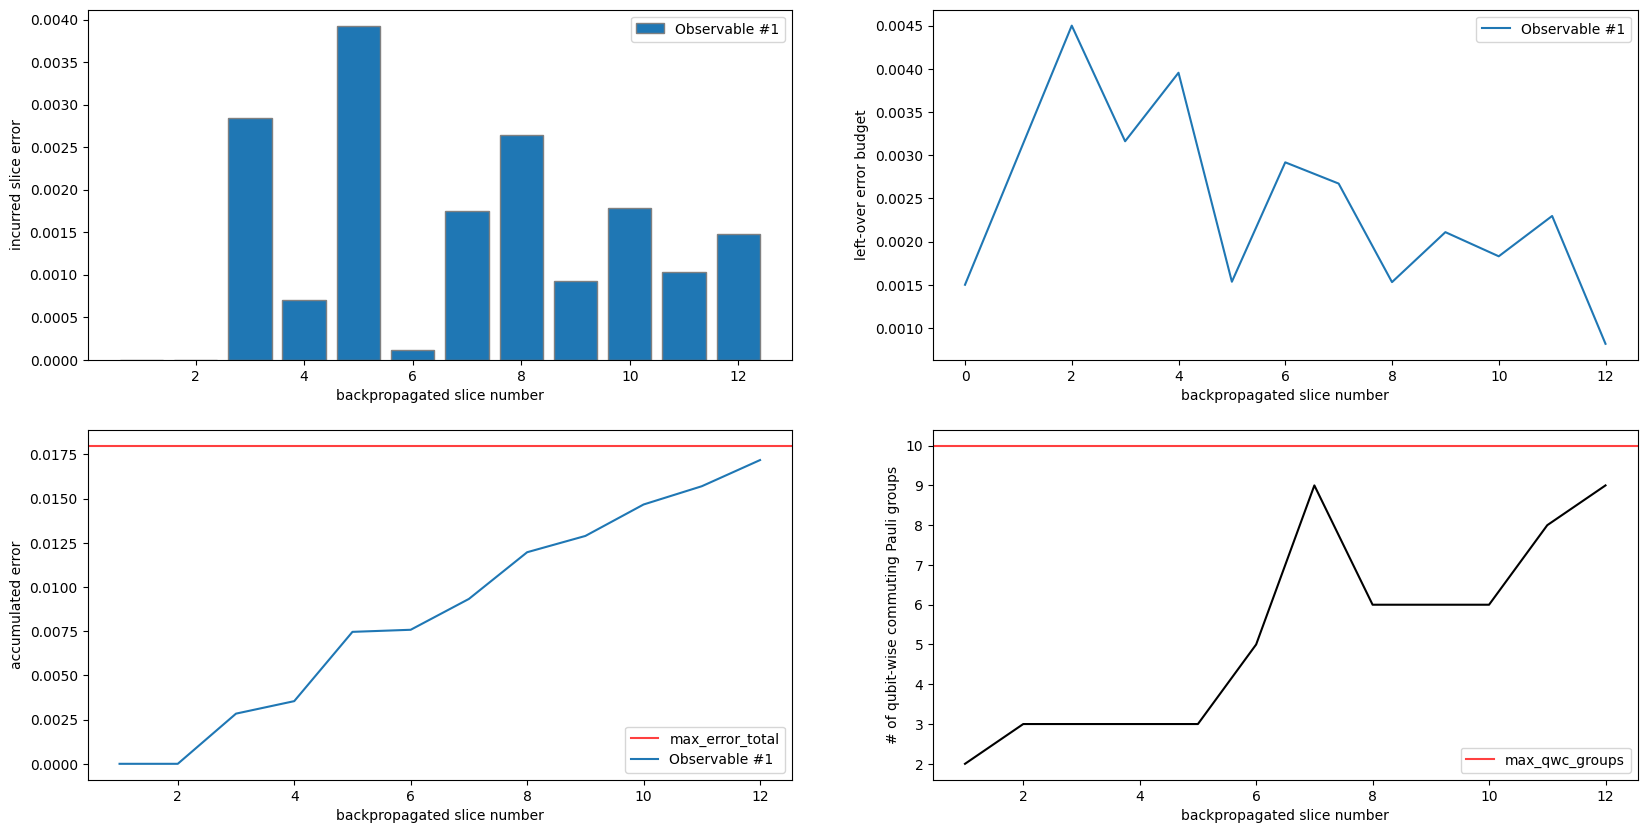

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
plot_slice_errors(metadata, axes[(0, 0)])
plot_left_over_error_budget(metadata, axes[(0, 1)])
plot_accumulated_error(metadata, axes[(1, 0)])
plot_num_qwc_groups(metadata, axes[(1, 1)])

## Working with multiple observables

The `qiskit_addon_obp.backpropagate` method allows one to pass in a sequence of observables. This simplifies the workflow when dealing with multiple target observables.

We explicitly mention this here to teach you how the truncation strategy handles such a case. For the sake of this example, we add an extra observable to the one which we have been using so far:

In [22]:
obs = [SparsePauliOp("IIIIIZIIII"), SparsePauliOp("IIIIIXIIII")]

For simplicity, we repeat the very first experiment from this tutorial. The only difference is that we now have two observables to backpropagate the circuit into.

For this particular example, this does not affect the number of slices which could be backpropagated. However, we can see now that the two observables resulted in different numbers of Pauli terms and commuting groups.

In [23]:
truncation_error_budget = setup_budget(max_error_per_slice=0.001)
print(truncation_error_budget)

TruncationErrorBudget(per_slice_budget=[0.001], max_error_total=inf, p_norm=1)


In [24]:
bp_obs, remaining_slices, metadata = backpropagate(
    obs, slices, operator_budget=op_budget, truncation_error_budget=truncation_error_budget
)
reduced_circuit = combine_slices(remaining_slices)
print(f"Backpropagated {len(slices) - len(remaining_slices)} circuit slices.")
print(
    f"The new first observable contains {len(bp_obs[0])} terms and {len(bp_obs[0].group_commuting(qubit_wise=True))} commuting groups."
)
print(
    f"The new second observable contains {len(bp_obs[1])} terms and {len(bp_obs[1].group_commuting(qubit_wise=True))} commuting groups."
)

Backpropagated 11 circuit slices.
The new first observable contains 29 terms and 10 commuting groups.
The new second observable contains 23 terms and 8 commuting groups.


The plots below shed some light on how the backpropagation algorithm handles multiple observables.

First, the plots **top/left**, **top/right** and **bottom/left** teach us that the budget for truncating terms is set individually for each observable. In other words, both observables have the ability to truncate terms assuming an error of `0.001` per backpropagated slice.
Due to the different nature of the observables, this results in different consumption of the budget. In this example, they exhibit a lot of overlap which is not necessarily the case in general.

**bottom/right** teaches us that `max_qwc_groups` is actually taking _all_ observables combined into account. That means that the terms of all observables are grouped together to arrive at one final number of qubit-wise commuting groups which is compared against `max_qwc_paulis`. The same is done for the `max_paulis` threshold (which we have not discussed in this notebook) which allows you to set a limit on the number of Pauli terms across all observables.

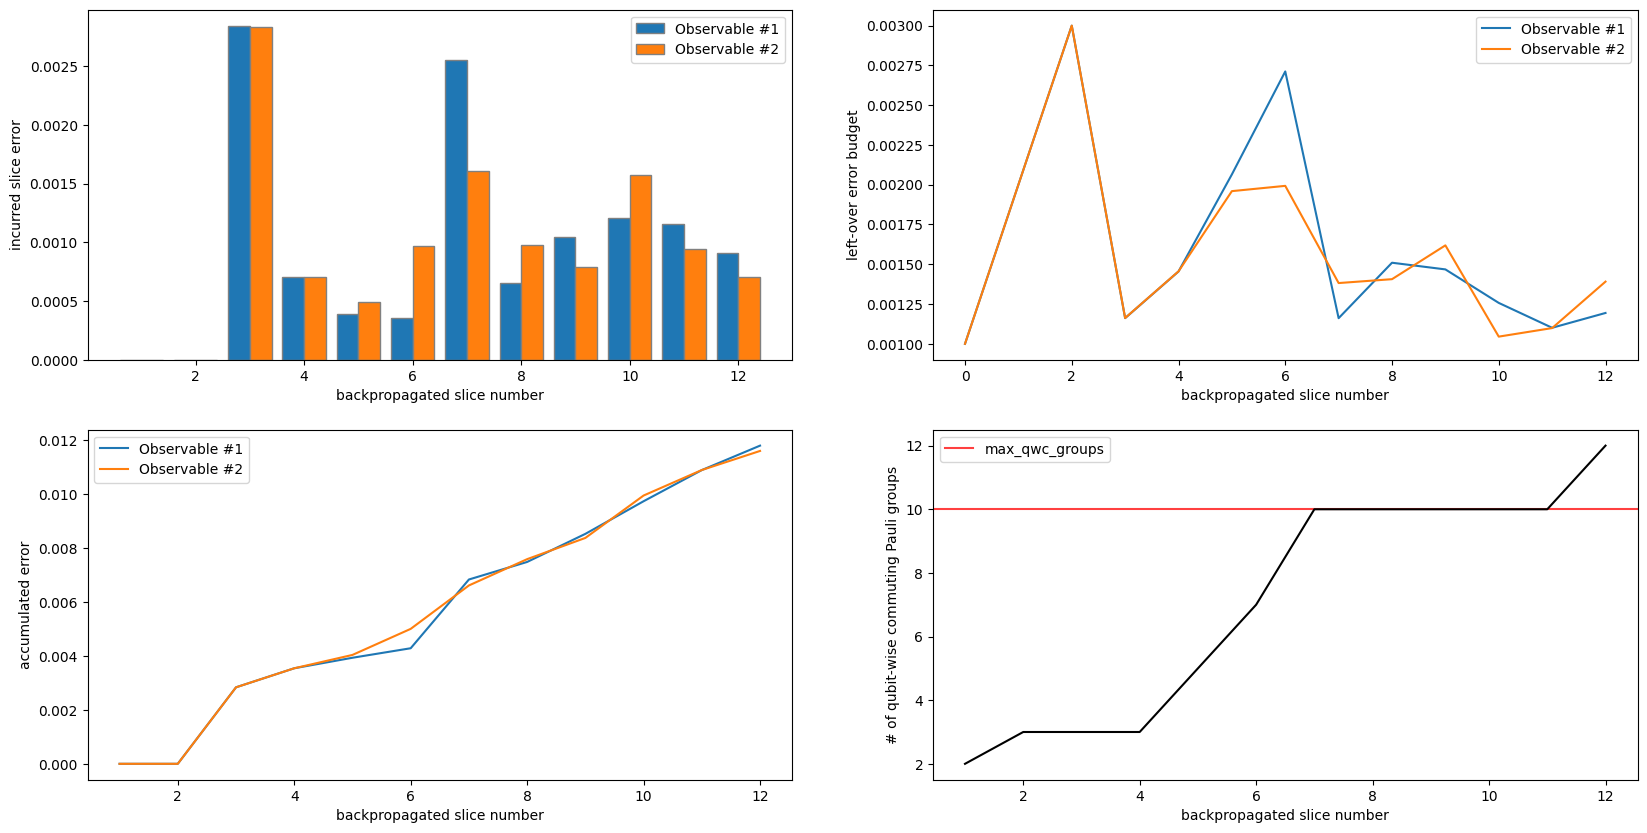

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
plot_slice_errors(metadata, axes[(0, 0)])
plot_left_over_error_budget(metadata, axes[(0, 1)])
plot_accumulated_error(metadata, axes[(1, 0)])
plot_num_qwc_groups(metadata, axes[(1, 1)])